In [1]:
#%%
from LiouvilleLanczos.Quantum_computer.QC_lanczos import Liouvillian_slo,inner_product_slo,sum_slo
from LiouvilleLanczos.Quantum_computer.Hamiltonian import Line_Hubbard,BoundaryCondition
from LiouvilleLanczos.Lanczos import Lanczos
from LiouvilleLanczos.matrix_impl import MatrixState_inner_product,Matrix_Liouvillian,Matrix_sum
from LiouvilleLanczos.Quantum_computer.Mapping import find_best_layout
from LiouvilleLanczos.Green import CF_Green
from qiskit.primitives import StatevectorEstimator as pEstimator

from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.operators import FermionicOp
from qiskit.quantum_info.operators import SparsePauliOp
from qiskit import QuantumCircuit
import numpy as np
from qiskit import transpile
from datetime import datetime
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

We start by initializing the Hubbard model Hamiltonian for a 2 site Line Lattice, in the second quantization:

$H = \sum_{i,j = 0}^1\sum_{\sigma = \uparrow, \downarrow} t \hspace{1mm} c^{\dag}_{i, \sigma} c_{j, \sigma} + U \sum_{i = 0}^{1} n_{i, \uparrow}n_{i,\downarrow}$

for U = 4, t = -1

In [2]:
U = 4
mapper = JordanWignerMapper()
Ham = Line_Hubbard(-1,U/2,U,2,boundary_condition=BoundaryCondition.OPEN)
#up spin site 1
C2 = FermionicOp(
    {
        "+_2": 1,
    },
    num_spin_orbitals=4,
)
#up spin site 0
C0 = FermionicOp(
    {
        "+_0": 1,
    },
    num_spin_orbitals=4,
)
C0_mat = mapper.map(C0).to_matrix()
C2_mat = mapper.map(C2).to_matrix()
print(Ham)

Fermionic Operator
number spin orbitals=4, number terms=10
  -1 * ( +_0 -_2 )
+ 1 * ( -_0 +_2 )
+ -2.0 * ( +_0 -_0 )
+ -2.0 * ( +_2 -_2 )
+ -1 * ( +_1 -_3 )
+ 1 * ( -_1 +_3 )
+ -2.0 * ( +_1 -_1 )
+ -2.0 * ( +_3 -_3 )
+ 4 * ( +_0 -_0 +_1 -_1 )
+ 4 * ( +_2 -_2 +_3 -_3 )


The algorithm consists of calculating the Green's function by (iteratively) evaluating expectation values of fermionic operators on some state. Here, we are interested in the model at 0 temperature, and thus compute expectation values on the ground state.

The circuit preparing the ground state was found by diagonalizing the hamiltonian analytically. For larger systems, a fully quantum algorithm could use a Hamiltonian simulation algorithm such as VQE to estimate the GS.

-4.82842712474619
-4.8284271246253425


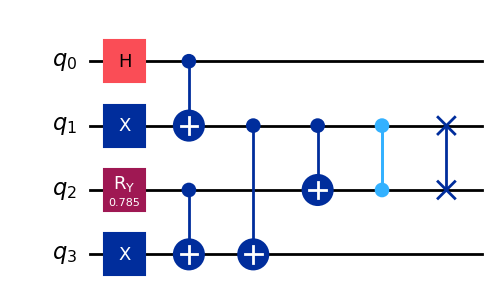

In [3]:
#%% Ground state circuit, obtained by inspection of analytical wavefunction
bt = 0.7854074074074073
GS_analytical = QuantumCircuit(4)
GS_analytical.h(0)
GS_analytical.x(1)
GS_analytical.cx(0,1)
GS_analytical.ry(bt,2)
GS_analytical.x(3)
GS_analytical.cx(2,3)
GS_analytical.cx(1,3)
GS_analytical.cx(1,2)
GS_analytical.cz(1,2)
GS_analytical.swap(1,2)

#%% Sanity check: compare matrix ground energy with simulated estimator ground energy.
Hmat = mapper.map(Ham).to_matrix()
estimator = pEstimator()
qubit_converter = (JordanWignerMapper())
HHam = qubit_converter.map(Ham)
E,S = np.linalg.eigh(Hmat)
GS_mat = S[:,0]
print(E[0])
print(estimator.run([(GS_analytical,HHam)]).result()[0].data.evs)
GS_analytical.draw('mpl')

From the analytic description of the GS, we can calculate the Green's function classically, for reference. 

In [4]:
#%% classical computation of the Green's function at site 0
matrix_lanczos = Lanczos(MatrixState_inner_product(GS_mat),Matrix_Liouvillian(),Matrix_sum())
a_ed,b_ed,mu_ed = matrix_lanczos.polynomial_hybrid(Hmat,C0_mat,[C2_mat],10)
green_ed = CF_Green(a_ed,b_ed)

# %% Quantum computer simulation
eps = 1e-6
SQ_inpro = inner_product_slo(GS_analytical,estimator,qubit_converter,eps)
SQ_Liou = Liouvillian_slo(eps)
lanczos = Lanczos(SQ_inpro,SQ_Liou,sum_slo(eps))
a_sim5,b_sim5,mu_sim5 = lanczos.polynomial_hybrid(Ham,C0,[C2],10,5e-3)

anomalous termination b at iteration 3
b^2=(1.4667882456453188e-30+0j) is smaller than 1e-13, terminating


UFuncTypeError: Cannot cast ufunc 'add' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'